## Import librairies
create a Python 3.9.19 env and install requirements.txt using\
or use environment.yml

In [1]:
#!pip install -r requirements.txt

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
import tiktoken
import seaborn as sns
import eli5

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier

In [3]:
import s3fs
import os

## Download dataset

In [4]:
# Create filesystem object
S3_ENDPOINT_URL = "https://" + os.environ["AWS_S3_ENDPOINT"]
fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': S3_ENDPOINT_URL})

In [5]:
fs.ls("civel/diffusion/hackathon-minarm-2024/AIVSAI")

['civel/diffusion/hackathon-minarm-2024/AIVSAI/.keep',
 'civel/diffusion/hackathon-minarm-2024/AIVSAI/HC3.zip',
 'civel/diffusion/hackathon-minarm-2024/AIVSAI/all.json',
 'civel/diffusion/hackathon-minarm-2024/AIVSAI/hack_train.csv',
 'civel/diffusion/hackathon-minarm-2024/AIVSAI/train.json']

In [6]:
files = ["hack_train.csv", "train.json", "all.json"]
for file in files:
    PATH_IN = f'civel/diffusion/hackathon-minarm-2024/AIVSAI/{file}'
    fs.download(PATH_IN, f'data/{file}')

## Load dataset
On va utilisé all.json pour l'entraînement et se concentrer pour avoir la meilleur généralisation, en testant le modèle sur le hack_train.json.

In [7]:
dataset = pd.read_json("data/all.json", lines=True)
dataset.head()

,question,human_answers,chatgpt_answers,index,source
0,"Why is every book I hear about a "" NY Times # ...","[Basically there are many categories of "" Best...",[There are many different best seller lists th...,NaN,reddit_eli5
1,"If salt is so bad for cars , why do we use it ...",[salt is good for not dying in car crashes and...,[Salt is used on roads to help melt ice and sn...,NaN,reddit_eli5
2,Why do we still have SD TV channels when HD lo...,[The way it works is that old TV stations got ...,[There are a few reasons why we still have SD ...,NaN,reddit_eli5
3,Why has nobody assassinated Kim Jong - un He i...,[You ca n't just go around assassinating the l...,[It is generally not acceptable or ethical to ...,NaN,reddit_eli5
4,How was airplane technology able to advance so...,[Wanting to kill the shit out of Germans drive...,[After the Wright Brothers made the first powe...,NaN,reddit_eli5


In [14]:
hack_data = pd.read_csv("data/hack_train.csv")
hack_data['generated'] = np.where(hack_data['label'] == 0, 1, 0)
hack_data.head()

,text,label,src,generated
0,Little disclaimer: this deals with US laws and...,1,cmv_human,0
1,"Read: Mentally Retarded Downs. See, we've got ...",1,cmv_human,0
2,"If any of you frequent rbadhistory, there is a...",1,cmv_human,0
3,"I believe in a flat tax system, where everyone...",1,cmv_human,0
4,"Edit: Ok guy's, my views have been changed on ...",1,cmv_human,0


## Analyse statistique HC3

In [16]:
human_df = pd.DataFrame({"text" : dataset["human_answers"], "generated": 0})
gpt_df = pd.DataFrame({"text" : dataset["chatgpt_answers"], "generated": 1})

human_df["text"] = human_df["text"].apply(lambda x: " ".join(x))
gpt_df["text"] = gpt_df["text"].apply(lambda x: " ".join(x))

df = pd.concat([human_df, gpt_df])
df.head()

,text,generated
0,"Basically there are many categories of "" Best ...",0
1,salt is good for not dying in car crashes and ...,0
2,The way it works is that old TV stations got a...,0
3,You ca n't just go around assassinating the le...,0
4,Wanting to kill the shit out of Germans drives...,0


In [17]:
print("Number of rows: ", df.shape[0])

Number of rows:  48644


Text(0.5, 1.0, 'Number of response per label')

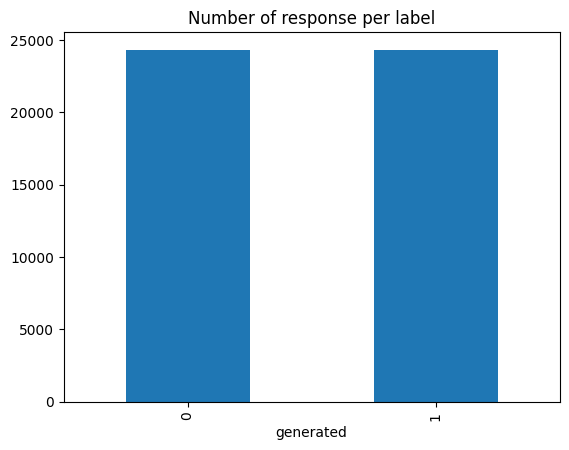

In [19]:
df.generated.value_counts().plot(kind='bar')
plt.title('Number of response per label')

La distribution est équilibrée entre nombre de texte généré et non-généré.

In [20]:
df['text_len'] = df.text.apply(len)
df['text_len'].describe()

count    48644.000000
mean      1362.575487
std       1144.406427
min          0.000000
25%        760.000000
50%       1095.000000
75%       1552.000000
max      35917.000000
Name: text_len, dtype: float64

Text(0.5, 1.0, 'Text length distribution')

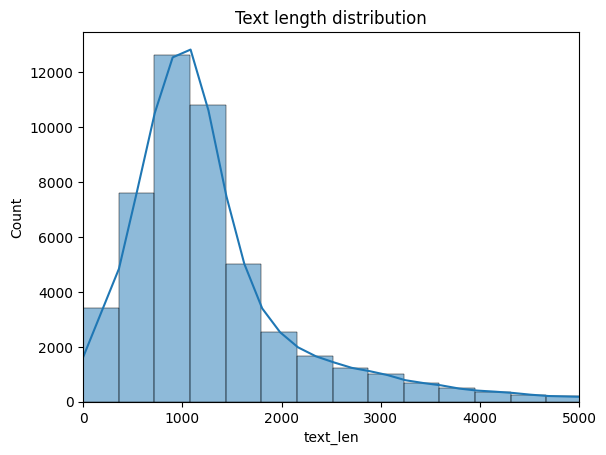

In [23]:
sns.histplot(df['text_len'], bins=100, kde=True)
plt.xlim(0, 5000)
plt.title('Text length distribution')

Text(0.5, 1.0, 'Text length distribution by label')

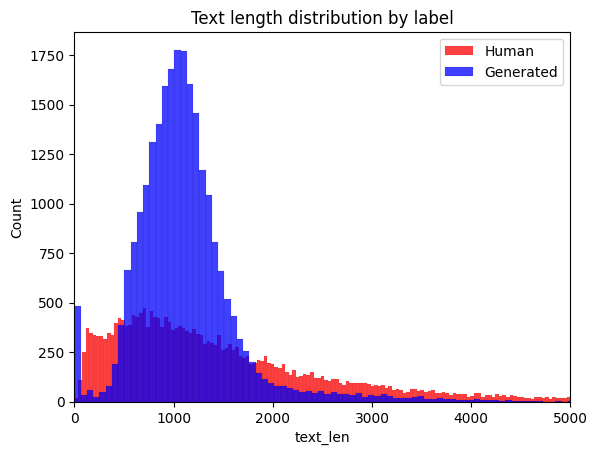

In [25]:
sns.histplot(df[df['generated'] == 0]['text_len'], bins=1000, color='red', label='Human')
sns.histplot(df[df['generated'] == 1]['text_len'], bins=100, color='blue', label='Generated')
plt.xlim(0, 5000)
plt.legend()
plt.title('Text length distribution by label')

La longueur des textes générés ont l'air de stationner autour de 1000 mots, avec très peu de variations, comparée aux réponses humaines. 

/opt/mamba/envs/iavsai/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'Top 20 most common words ignoring stop words')

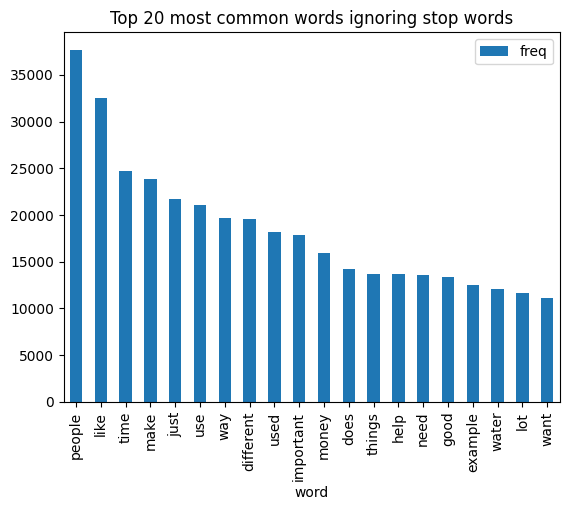

In [28]:
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(df.text)
word_freq = np.array(X.sum(axis=0)).flatten()
word_freq_df = pd.DataFrame({'word': vectorizer.get_feature_names(), 'freq': word_freq})
word_freq_df = word_freq_df.sort_values(by='freq', ascending=False)
word_freq_df.head(20).plot(kind='bar', x='word', y='freq')
plt.title('Top 20 most common words ignoring stop words')

Les mots les plus utilisés sont-il les mêmes pour les réponses générés et non-généré.

/opt/mamba/envs/iavsai/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'Top 20 most common words ignoring stop words (Human)')

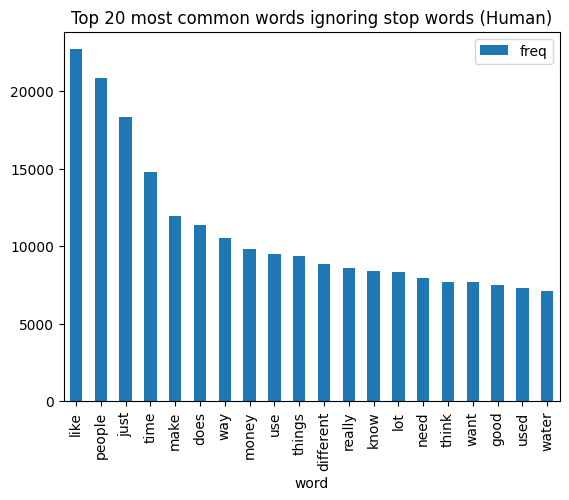

In [30]:
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(df[df.generated == 0].text)
word_freq = np.array(X.sum(axis=0)).flatten()
word_freq_df = pd.DataFrame({'word': vectorizer.get_feature_names(), 'freq': word_freq})
word_freq_df = word_freq_df.sort_values(by='freq', ascending=False)
word_freq_df.head(20).plot(kind='bar', x='word', y='freq')
plt.title('Top 20 most common words ignoring stop words (Human)')

/opt/mamba/envs/iavsai/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'Top 20 most common words ignoring stop words (Generated)')

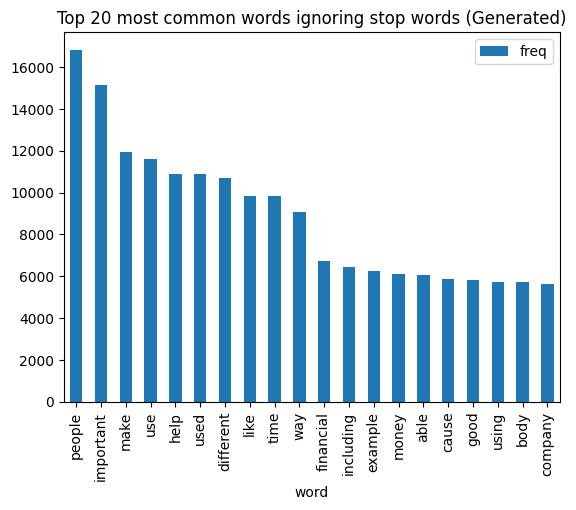

In [31]:
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(df[df.generated == 1].text)
word_freq = np.array(X.sum(axis=0)).flatten()
word_freq_df = pd.DataFrame({'word': vectorizer.get_feature_names(), 'freq': word_freq})
word_freq_df = word_freq_df.sort_values(by='freq', ascending=False)
word_freq_df.head(20).plot(kind='bar', x='word', y='freq')
plt.title('Top 20 most common words ignoring stop words (Generated)')

'Important' n'est présent dans le top 20 uniquement dans les textes générées. 🧐

## Analyse statistique hack_train

In [34]:
df = hack_data
df.head()

,text,label,src,generated
0,Little disclaimer: this deals with US laws and...,1,cmv_human,0
1,"Read: Mentally Retarded Downs. See, we've got ...",1,cmv_human,0
2,"If any of you frequent rbadhistory, there is a...",1,cmv_human,0
3,"I believe in a flat tax system, where everyone...",1,cmv_human,0
4,"Edit: Ok guy's, my views have been changed on ...",1,cmv_human,0


In [35]:
print("Number of rows: ", df.shape[0])

Number of rows:  56819


Text(0.5, 1.0, 'Number of response per label')

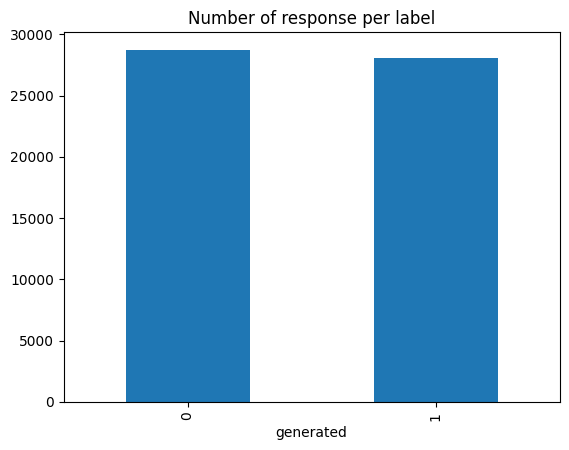

In [42]:
df.generated.value_counts().plot(kind='bar')
plt.title('Number of response per label')

Les données sont aussi équilibrées.

Text(0.5, 1.0, 'Top 20 sources')

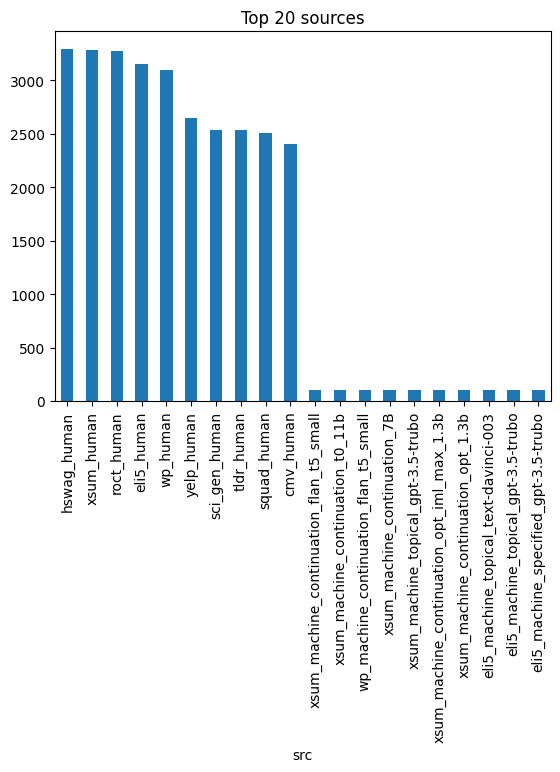

In [37]:
df.src.value_counts()[:20].plot(kind='bar')
plt.title('Top 20 sources')

Les données sont bien équilibrés entre généré et no-généré mais cette équilibre n'est pas présent au sein des sources des réponses.
Les réponses humaines proviennent majoritaire de quelques sources (bien moindre que les textes générés).

In [38]:
df['text_len'] = df.text.apply(len)
df['text_len'].describe()

count    56819.000000
mean      1230.017846
std       1468.620465
min         24.000000
25%        283.000000
50%        677.000000
75%       1526.000000
max      63723.000000
Name: text_len, dtype: float64

Text(0.5, 1.0, 'Text length distribution')

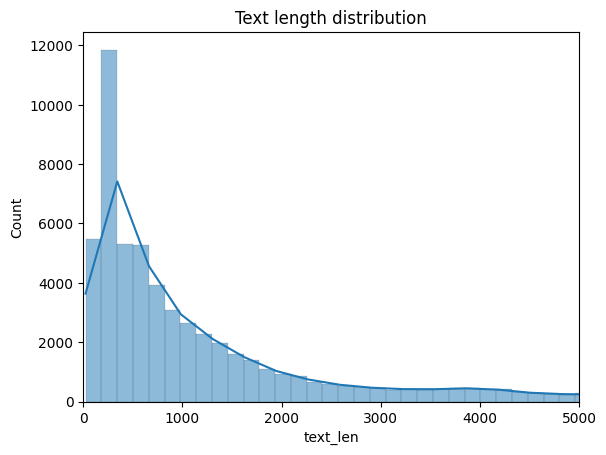

In [44]:
sns.histplot(df['text_len'], bins=400, kde=True)
plt.xlim(0, 5000)
plt.title('Text length distribution')

Text(0.5, 1.0, 'Text length distribution by label')

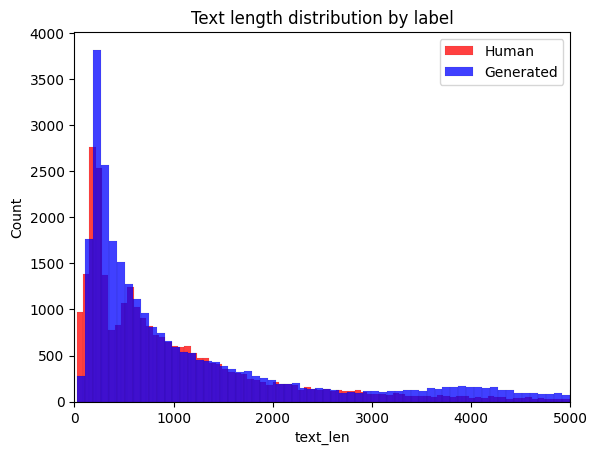

In [41]:
sns.histplot(df[df['generated'] == 0]['text_len'], bins=1000, color='red', label='Human')
sns.histplot(df[df['generated'] == 1]['text_len'], bins=100, color='blue', label='Generated')
plt.xlim(0, 5000)
plt.legend()
plt.title('Text length distribution by label')

Les textes longs sont plutôt des textes générés

In [45]:
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(df.text)
word_freq = np.array(X.sum(axis=0)).flatten()
word_freq_df = pd.DataFrame({'word': vectorizer.get_feature_names(), 'freq': word_freq})
word_freq_df = word_freq_df.sort_values(by='freq', ascending=False)

/opt/mamba/envs/iavsai/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'Top 20 most common words ignoring stop words')

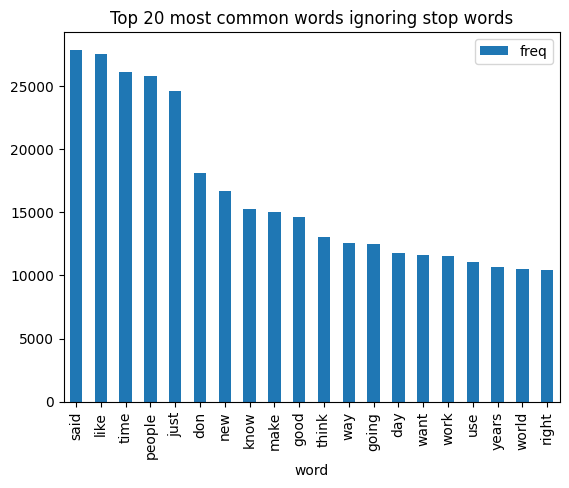

In [46]:
word_freq_df.head(20).plot(kind='bar', x='word', y='freq')
plt.title('Top 20 most common words ignoring stop words')

Les mots sont-ils les mêmes pour des textes générés et non-générés?

/opt/mamba/envs/iavsai/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'Top 20 most common words ignoring stop words (Human)')

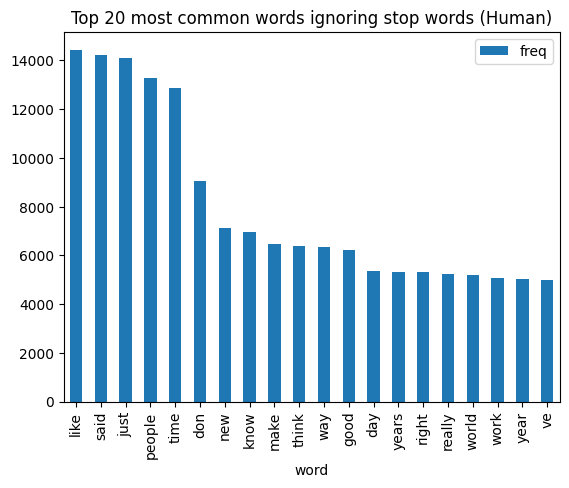

In [47]:
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(df[df.generated == 0].text)
word_freq = np.array(X.sum(axis=0)).flatten()
word_freq_df = pd.DataFrame({'word': vectorizer.get_feature_names(), 'freq': word_freq})
word_freq_df = word_freq_df.sort_values(by='freq', ascending=False)
word_freq_df.head(20).plot(kind='bar', x='word', y='freq')
plt.title('Top 20 most common words ignoring stop words (Human)')

/opt/mamba/envs/iavsai/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'Top 20 most common words ignoring stop words (Generated)')

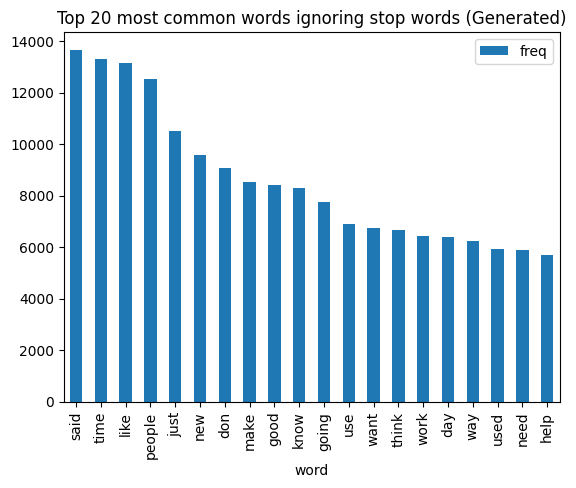

In [48]:
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(df[df.generated == 1].text)
word_freq = np.array(X.sum(axis=0)).flatten()
word_freq_df = pd.DataFrame({'word': vectorizer.get_feature_names(), 'freq': word_freq})
word_freq_df = word_freq_df.sort_values(by='freq', ascending=False)
word_freq_df.head(20).plot(kind='bar', x='word', y='freq')
plt.title('Top 20 most common words ignoring stop words (Generated)')

Les mots sont similaires.

In [49]:
df["w_count"] = df.text.apply(lambda x: vectorizer.fit_transform([x]).shape[1])

In [50]:
df['w_count'].describe()

count    56819.000000
mean        76.407487
std         87.246592
min          1.000000
25%         21.000000
50%         47.000000
75%         95.000000
max       2448.000000
Name: w_count, dtype: float64

Text(0.5, 1.0, 'Word count distribution by label')

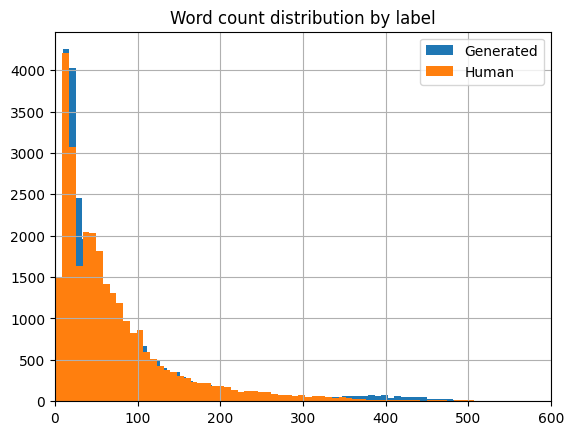

In [57]:
df[df['generated'] == 1]['w_count'].hist(bins=100, label='Generated')
df[df['generated'] == 0]['w_count'].hist(bins=300, label='Human')
plt.xlim(0, 600)
plt.legend()
plt.title('Word count distribution by label')

In [58]:
df['avg_word_len'] = df['text_len'] / df['w_count']

Text(0.5, 1.0, 'Average word length distribution by label')

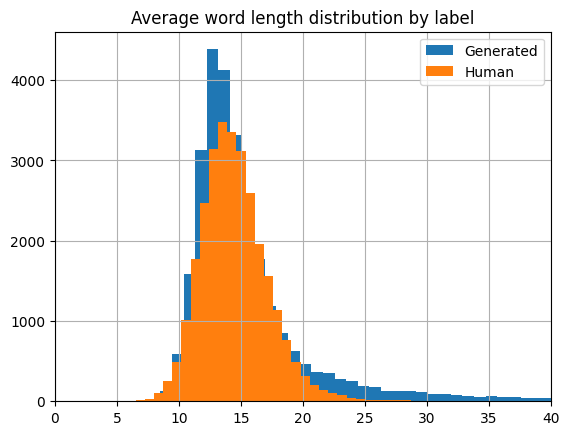

In [59]:
df[df['generated'] == 1]['avg_word_len'].hist(label='Generated', bins=500)
df[df['generated'] == 0]['avg_word_len'].hist(label='Human', bins=100)
plt.xlim(0, 40)
plt.legend()
plt.title('Average word length distribution by label')

L'utilisation de mots plus long semble être une caractéristique d'IA.

In [27]:
def load_hack_data() -> [pd.Series, pd.Series]:
    """
    Load the test data (hack_train.csv).
    hack_train "label" column correspond to "is_human" (0: False, 1: True)
    A "generated" column is added to correspond to "is_generated". 

    Returns:
        [pandas.Series, pandas.Series]: X_test and y_test
    """
    hack_data = pd.read_csv("data/hack_train.csv")
    hack_data["generated"] = np.where(hack_data["label"] == 0, 1, 0)
    hack_data.drop(columns=["label", "src"], inplace=True)
    X_test, y_test = hack_data["text"], hack_data["generated"]

    return X_test, y_test

In [28]:
x_hack, y_hack = load_hack_data()

## Preprocess
On décide de ne pas utiliser les questions, et de se fier uniquement aux réponses pour une question de simplicité.

In [14]:
def preprocess_v1_df() -> pd.DataFrame:
    """
    using data/all.json (questions, human_answers, chatgpt_answer, ...)
    Join the list of sentence from each response.
    Merge human_answers on top of chatgpt_answers as a single 'text' column.
    Questions are considered not necessary for now.

    Returns:
        pd.DataFrame: columns: text, generated
    """
    dataset = pd.read_json("data/all.json", lines=True)
    human_df = pd.DataFrame({"text" : dataset["human_answers"], "generated": 0})
    gpt_df = pd.DataFrame({"text" : dataset["chatgpt_answers"], "generated": 1})

    human_df["text"] = human_df["text"].apply(lambda x: " ".join(x))
    gpt_df["text"] = gpt_df["text"].apply(lambda x: " ".join(x))

    df = pd.concat([human_df, gpt_df])
    return df


In [15]:
df = preprocess_v1_df()
df.head()

,text,generated
0,"Basically there are many categories of "" Best ...",0
1,salt is good for not dying in car crashes and ...,0
2,The way it works is that old TV stations got a...,0
3,You ca n't just go around assassinating the le...,0
4,Wanting to kill the shit out of Germans drives...,0


## Training and test sets

In [62]:
X = df['text']
y = df['generated']

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

## Entraînement: Naive Bayes

In [64]:
# Can take up to 20 minutes to run
model = make_pipeline(CountVectorizer(), MultinomialNB())

param_grid = {
    'countvectorizer__ngram_range': [(1, 1), (2, 2)], # (3,3) is too taxing on memory
    'countvectorizer__lowercase': [True, False],
}

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1_macro', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

best_model = grid_search.best_estimator_
test_score = best_model.score(X_test, y_test)
print("Test set score:", test_score)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters: {'countvectorizer__lowercase': False, 'countvectorizer__ngram_range': (2, 2)}
Best cross-validation score: 0.9311548347219809
Test set score: 0.9362144420131291


In [65]:
y_pred = best_model.predict(X_test)

print(f"Features dimension: {len(X_train), len(best_model[0].vocabulary_)}")
print("Classification Report:\n", classification_report(y_test, y_pred))

Features dimension: (36556, 1824886)
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.90      0.93      4482
           1       0.91      0.97      0.94      4658

    accuracy                           0.94      9140
   macro avg       0.94      0.94      0.94      9140
weighted avg       0.94      0.94      0.94      9140



Bons résultats, comparons avec une régression logistique.

## Entraînement: Logistic Regression

### Basic Logistic Regression

In [18]:
model = make_pipeline(CountVectorizer(), LogisticRegression(random_state=42))

In [19]:
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(f"Features dimension: {len(X_train), len(model[0].vocabulary_)}")
print("Classification Report:\n", classification_report(y_test, y_pred))

/opt/mamba/envs/iavsai/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Features dimension: (38915, 77703)
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.97      0.96      4825
           1       0.97      0.95      0.96      4904

    accuracy                           0.96      9729
   macro avg       0.96      0.96      0.96      9729
weighted avg       0.96      0.96      0.96      9729



ConvergenceWarning: lbfgs failed to converge (status=1): STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.\
On va essayer avec un autre solver.

### Logistic Regression with another liblinear solver

In [20]:
model = make_pipeline(CountVectorizer(), LogisticRegression(random_state=42, solver = 'liblinear'))

In [21]:
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(f"Features dimension: {len(X_train), len(model[0].vocabulary_)}")
print("Classification Report:\n", classification_report(y_test, y_pred))

Features dimension: (38915, 77703)
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.97      0.96      4825
           1       0.97      0.95      0.96      4904

    accuracy                           0.96      9729
   macro avg       0.96      0.96      0.96      9729
weighted avg       0.96      0.96      0.96      9729



In [22]:
hack_pred = model.predict(x_hack)

print("Classification Report:\n", classification_report(y_hack, hack_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.52      0.86      0.65     28741
           1       0.58      0.19      0.29     28078

    accuracy                           0.53     56819
   macro avg       0.55      0.53      0.47     56819
weighted avg       0.55      0.53      0.47     56819



Le modèle a une bonne performance sur des données similaires aux données d'entraînement (finance, medecine, openqd, reddit, wiki).
Mais en transférant sur un nouveau dataset (hack_train), on peut remarquer une baisse en accuracy. Overfit? Manque de pouvoir de généralisation?

In [37]:
def count_zeros(*arrays):
    """
    Returns the number of zeros.
    Will be used to count the number of parameters that actually have an effect on a Logistic Regression.
    """
    combined_array = np.concatenate(arrays)
    zero_count = np.sum(combined_array == 0)
    return zero_count

In [38]:
def parameters_zeros_info(model) -> None:
    """
    Prints information on model's coef, number of parameters, of zeros, non-zeros.
    """
    nb_parameters = model[1].coef_.shape[0]*model[1].coef_.shape[1]
    print("Model parameters:",nb_parameters)
    nb_zero = count_zeros(model[1].coef_)
    print(f"Total number of zeros: {nb_zero}")
    print(f"Toal number non-zeros: {nb_parameters - nb_zero}")

In [25]:
parameters_zeros_info(model)

Model parameters: 77703
Total number of zeros: 0
Toal number non-zeros: 77703


## Analyse des résultats

### Plot confusion matrix

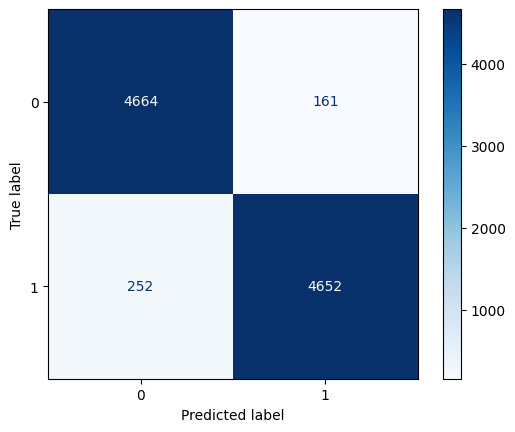

In [26]:
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [27]:
accuracy = model.score(X_test, y_test)
print("Accuracy:", accuracy)

Accuracy: 0.9575495939973275


Avec un modèle leger et très simple on obtient déjà une très bonne précision.

### Importance des différentes features

In [28]:
html = eli5.show_weights(estimator=model, top=(20, 20))
html

/opt/mamba/envs/iavsai/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Weight?,Feature
+2.226,important
+2.116,sorry
+1.673,generating
+1.539,questions
+1.514,including
+1.473,finally
+1.398,overall
+1.321,helps
+1.301,help
+1.285,imagine


La présence des mots 'important', 'sorry', 'generating', 'questions', 'including' tendent à faire penser que la réponse provient de chatGPT.\
Dans l'autre sens, la présence des mots 'url_0', 'ca', 'etc, 'basically' tendent à faire penser au modèle que la réponse est humaine.\
Les fautes d'orthographes, les mots familiers, les abbréviations ont l'air des features intéressantes à exploiter.

Les poids données à certaines features sont très hautes, elle impactent très fortement le modèle. Il serait judicieux d'utiliser une régulation L1/L2 pour empêcher de donner trop d'importance à une seule feature.

#### Analysons les phrases contenant les mots d'importance

In [29]:
df[df.text.str.contains("important")].groupby("generated").count()

,text
generated,
0,2222
1,9858


'important' est plus présent dans les réponses de chatGPT, est-ce que chatGPT l'utilise + ou possédons nous des données inéquitablement distributées.

In [30]:
df[df.text.str.contains("important")].groupby("generated").first()

,text
generated,
0,salt is good for not dying in car crashes and ...
1,There are many different best seller lists tha...


Rien de flagrant.
Mais peut remarquer que l'humain a l'air de moins utiliser de majuscules que chatGPT.

In [31]:
df[df.text.str.contains("sorry")].groupby("generated").count()

,text
generated,
0,225
1,530


In [32]:
df[df.text.str.contains("generating")].groupby("generated").count()

,text
generated,
0,110
1,210


In [33]:
df[df.text.str.contains("generating") & (df.generated == 1)].head(20)

,text,generated
219,"Freckles and other skin imperfections, like mo...",1
1205,When people say that the US government lost $2...,1
1255,"Yes, it is possible to make videos using code....",1
1502,It's important to note that Amazon is not cons...,1
1535,Charcoal and regular coal are similar in that ...,1
1565,Tattoos don't disappear because the ink that i...,1
1818,"Sure! When an airplane flies through the air, ...",1
1960,Cold fusion is a type of nuclear reaction that...,1
2037,The scrambled letters and numbers that you som...,1
2285,Nuclear fusion is a process in which atomic nu...,1


#!, network error, There was an error generatin...\
Des mauvaises data introduites par des erreurs sur chatGPT.
Il faudra les supprimer.

In [34]:
df[df.text.str.contains("error generating")].head(20)

,text,generated
2345,"!, network error, There was an error generatin...",1
2392,"!, network error, There was an error generatin...",1
3252,"!, network error, There was an error generatin...",1
3379,"!, network error, There was an error generatin...",1
3844,"!, network error, There was an error generatin...",1
6702,!network errorThere was an error generating a ...,1
6703,!Only one message at a time. Please allow any ...,1
7312,!network errorThere was an error generating a ...,1
7313,!Only one message at a time. Please allow any ...,1
7706,!network errorThere was an error generating a ...,1


In [35]:
df[df.text.str.contains("error generating")].groupby("generated").count()

,text
generated,
1,98


98 mauvaises data.

In [36]:
df[df.text.str.contains(" ca ")].groupby("generated").count()

,text
generated,
0,3536
1,2


In [37]:
df[df.text.str.contains(" ca ")].groupby("generated").first()

,text
generated,
0,The way it works is that old TV stations got a...
1,Why ca n't we eat other people? I get the mora...


Bizarre une faute d'orthographe par chatGPT.

## Preprocess V2
On va supprimer les données dupliquées, les mauvaises données dues à une erreur de l'API chatGPT (error generating).

In [38]:
print("Taille avant suppression:", len(df))

Taille avant suppression: 48644


In [39]:
df.drop_duplicates(inplace=True)
print("Taille après suppression des doublons:", len(df))

Taille après suppression des doublons: 45746


In [40]:
df = df[~df.text.str.contains("error generating")]
print("Taille après des erreurs API chatGPT:", len(df))

Taille après des erreurs API chatGPT: 45696


In [17]:
def preprocess_v2_df() -> pd.DataFrame:
    """
    using data/all.json (questions, human_answers, chatgpt_answer, ...)
    Join the list of sentence from each response.
    Merge human_answers on top of chatgpt_answers as a single 'text' column.
    Questions are considered not necessary for now.

    duplicates are removed.
    chatGPT responses that are due to API error are removed. 

    Returns:
        pd.DataFrame: columns: text, generated 

    Returns:
        pd.DataFrame: text, generated
    """
    # preprocess V2 data
    human_df = pd.DataFrame({"text" : dataset["human_answers"], "generated": 0})
    gpt_df = pd.DataFrame({"text" : dataset["chatgpt_answers"], "generated": 1})

    human_df["text"] = human_df["text"].apply(lambda x: " ".join(x))
    gpt_df["text"] = gpt_df["text"].apply(lambda x: " ".join(x))

    df = pd.concat([human_df, gpt_df])
    df.drop_duplicates(inplace=True)
    df = df[~df.text.str.contains("error generating")]
    return df

In [42]:
X = df['text']
y = df['generated']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

## Entraînement V2

Entraînement sur les data avec le nouveau préprocessing.\
Cross validation.\
Régularisation pour empêcher un poids d'être trop important.\
GridSearch pour trouver les meilleurs hyperparamètres (taille des n-grams pour le tf-idf, lowercase ou non, learning rate, type de regularisation).

### Ensembling logistic regression + Naive Bayes

In [60]:
log_clf = LogisticRegression(random_state=42, max_iter=1000, solver='liblinear')
nb_clf = MultinomialNB()

voting_clf = VotingClassifier(estimators=[('lr', log_clf), ('nb', nb_clf)], voting='soft')

model = make_pipeline(CountVectorizer(), voting_clf)

### Cross validation

In [61]:
scoring = 'f1_macro'
scores = cross_val_score(model, X, y, cv=5, scoring=scoring, n_jobs = -1)
print(f"Mean {scoring}: {scores.mean()}")
print(f"Standard deviation {scoring}: {scores.std()}")

Mean f1_macro: 0.6151385499707435
Standard deviation f1_macro: 0.05646017874498643


Le F1 score est moins bon que la régression logistique, on va mettre le Naive Bayes  de côté pour le moment.

### Optimize hyperparameters using Grid Search on LogisticRegression

In [45]:
# Can take up to 20 minutes to run
# model = make_pipeline(CountVectorizer(), LogisticRegression(random_state=42, class_weight='balanced', solver='liblinear'))

# param_grid = {
#     'countvectorizer__ngram_range': [(1, 1), (2, 2)], # (3,3) is too taxing on memory
#     'countvectorizer__lowercase': [True, False],
#     'logisticregression__C': [0.001, 0.01, 0.1, 1],
#     'logisticregression__penalty': ['l1', 'l2'],
# }

# grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1_macro', verbose=1, n_jobs=-1)
# grid_search.fit(X_train, y_train)

# print("Best parameters:", grid_search.best_params_)
# print("Best cross-validation score:", grid_search.best_score_)

# best_model = grid_search.best_estimator_
# test_score = best_model.score(X_test, y_test)
# print("Test set score:", test_score)

Les meilleurs résultats ont été obtenus avec : \

Fitting 5 folds for each of 72 candidates, totalling 360 fits\
Best parameters: {'countvectorizer__lowercase': False, 'countvectorizer__ngram_range': (2, 2), 'logisticregression__C': 0.1, 'logisticregression__penalty': 'l2'}\
Best cross-validation score: 0.9716234041353873\
Test set score: 0.9733785589474766

In [46]:
model = make_pipeline(CountVectorizer(ngram_range=(2,2), lowercase=False), LogisticRegression(random_state=42, class_weight='balanced', solver='liblinear', C=0.1, penalty='l2'))

In [47]:
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(f"Features dimension: {len(X_train), len(model[0].vocabulary_)}")
print("Classification Report:\n", classification_report(y_test, y_pred))

Features dimension: (36556, 1824886)
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98      4482
           1       0.99      0.97      0.98      4658

    accuracy                           0.98      9140
   macro avg       0.98      0.98      0.98      9140
weighted avg       0.98      0.98      0.98      9140



In [48]:
hack_pred = model.predict(x_hack)

print("Classification Report:\n", classification_report(y_hack, hack_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.99      0.69     28741
           1       0.89      0.10      0.18     28078

    accuracy                           0.55     56819
   macro avg       0.71      0.54      0.43     56819
weighted avg       0.71      0.55      0.44     56819



On obtient des meilleurs résultats de transfert sur hack_train, 55% -> 71% accuracy.

In [49]:
parameters_zeros_info(model)

Model parameters: 1824886
Total number of zeros: 0
Toal number non-zeros: 1824886


## Analyse V2
Avec un modèle plus lourd mais toujours simple (sans deep learning) on garde une très bonne précision.

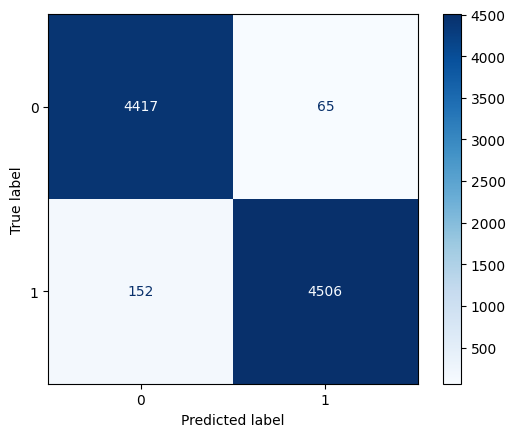

In [50]:
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Textes que le modèle a mal prédis

In [51]:
df.iloc[y_test[y_test != y_pred].index]

,text,generated
20180,The websites of the most publicly traded compa...,0
18564,"Data analysis is a process of inspecting, cle...",0
19906,Many of the above comments are correct about i...,0
6149,It 's not an explosion. It 's a loud boom that...,0
3429,"In the days of typewriters, the keys were alph...",0
...,...,...
7685,[ Here 's a video of an F-4 Phantom jet going ...,0
18968,The European Commission (EC) is the executive ...,0
4258,The hydropower waterfall 's water will hit the...,0
7525,You 're missing the 22 chromosomes that are n'...,0


In [52]:
html = eli5.show_weights(estimator=model, top=(20, 20))
html

/opt/mamba/envs/iavsai/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Weight?,Feature
+1.313,important to
+1.079,Does that
+0.957,helps to
+0.857,This can
+0.843,because it
+0.842,sorry but
+0.806,It important
+0.803,because they
+0.753,When you
+0.736,possible that


L'importance des poids unique est bien réduite.\
'Important to' fait fortement penser à une réponse de chatGPT.\
De l'autre côté la formulation moins soutenue et les fautes de grammaire/orthographe.

## Preprocess V3: Rajouter l'information de la question
Sous la forme "\<Q\>: {question} \<R\> Response: {reponse}"

In [53]:
human_df = pd.DataFrame({"text" : dataset["human_answers"], "generated": 0})
gpt_df = pd.DataFrame({"text" : dataset["chatgpt_answers"], "generated": 1})

human_df["text"] = human_df["text"].apply(lambda x: " ".join(x))
human_df["text"] = "<Q>" + dataset["question"] + "<R>" + human_df["text"]

gpt_df["text"] = gpt_df["text"].apply(lambda x: " ".join(x))
gpt_df["text"] = "<Q>" + dataset["question"] + "<R>" + gpt_df["text"]

df = pd.concat([human_df, gpt_df])
df.drop_duplicates(inplace=True)
df = df[~df.text.str.contains("error generating")]
df.head()

,text,generated
0,"<Q>Why is every book I hear about a "" NY Times...",0
1,"<Q>If salt is so bad for cars , why do we use ...",0
2,<Q>Why do we still have SD TV channels when HD...,0
3,<Q>Why has nobody assassinated Kim Jong - un H...,0
4,<Q>How was airplane technology able to advance...,0


In [54]:
X = df['text']
y = df['generated']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

## Entraînement V3

In [57]:
# Can take up to 20 minutes to run
# model = make_pipeline(CountVectorizer(), LogisticRegression(random_state=42, class_weight='balanced', solver='liblinear'))

# param_grid = {
#     'countvectorizer__ngram_range': [(1, 1), (2, 2)], # (3,3) is too taxing on memory
#     'countvectorizer__lowercase': [True, False],
#     'logisticregression__C': [0.001, 0.01, 0.1],
#     'logisticregression__penalty': ['l1', 'l2'],
# }

# grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1_macro', verbose=1, n_jobs=-1)
# grid_search.fit(X_train, y_train)

# print("Best parameters:", grid_search.best_params_)
# print("Best cross-validation score:", grid_search.best_score_)

# best_model = grid_search.best_estimator_
# test_score = best_model.score(X_test, y_test)
# print("Test set score:", test_score)

Best parameters: {'countvectorizer__lowercase': False, 'countvectorizer__ngram_range': (2, 2), 'logisticregression__C': 0.1, 'logisticregression__penalty': 'l2'}\
Best cross-validation score: 0.9721703614466234\
Test set score: 0.9718280025418343

In [58]:
model = make_pipeline(CountVectorizer(ngram_range=(2,2), lowercase=False), LogisticRegression(random_state=42, class_weight='balanced', solver='liblinear', C=0.1, penalty='l2'))

In [59]:
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(f"Features dimension: {len(X_train), len(model[0].vocabulary_)}")
print("Classification Report:\n", classification_report(y_test, y_pred))

Features dimension: (37766, 1959873)
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97      4689
           1       0.98      0.96      0.97      4753

    accuracy                           0.97      9442
   macro avg       0.97      0.97      0.97      9442
weighted avg       0.97      0.97      0.97      9442



In [60]:
hack_pred = model.predict(x_hack)

print("Classification Report:\n", classification_report(y_hack, hack_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.52      1.00      0.68     28741
           1       0.94      0.05      0.10     28078

    accuracy                           0.53     56819
   macro avg       0.73      0.52      0.39     56819
weighted avg       0.73      0.53      0.39     56819



Encore mieux en en transfert sur hack_train sur la prédiction des textes générés.\
Mais le F1 score reste légèrement au dessus de 0.5 et 0.39 en pondérée.\
Le preprocessing V2 reste meilleur sur le F1 score.

In [61]:
parameters_zeros_info(model)

Model parameters: 1959873
Total number of zeros: 0
Toal number non-zeros: 1959873


## Analyse V3

In [62]:
html = eli5.show_weights(estimator=model, top=(20, 20))
html

/opt/mamba/envs/iavsai/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Weight?,Feature
+1.899,like five
+1.459,Explain like
+1.445,important to
+1.025,five Sure
+0.854,helps to
+0.848,This can
+0.794,It important
+0.762,Does that
+0.709,example if
+0.701,possible that


On a la même accuracy mais le modèle a l'air de overfit, rajouter la question ne semble pas être pertinent.

Le meilleur modèle serait donc le suivant :
```python
    model = make_pipeline(CountVectorizer(ngram_range=(2,2), lowercase=False), LogisticRegression(random_state=42, class_weight='balanced', solver='liblinear', C=0.1, penalty='l2'))
```

## Feature engineering
### Spell checking
Process takes too long will no be retained as possible solution

In [63]:
# from spellchecker import SpellChecker
# from nltk import word_tokenize          
# import nltk

In [64]:
# spell = SpellChecker()

In [65]:
# df = preprocess_v2_df()
# df["text"] = df["text"].apply(lambda x: x.lower())
# df.head()

In [66]:
# # Using tokenizer takes too long combined with spell checking
# # It will not be retained as solution
# def nltk_tokenize(doc):
#     return [t for t in word_tokenize(doc)]

In [67]:
# import re

# def remove_punctuation(s: str) -> str:
#     """
#     remove punctuation from s

#     Args:
#         s (str): string with punctuation

#     Returns:
#         str: string without punctuation
#     """
#     result = re.sub(r'[\.,:?!"]', '', s, flags=re.IGNORECASE)
#     return result

In [68]:
# df["text"] = df.text.apply(lambda x: remove_punctuation(x))
# df.head()

In [69]:
# Takes too long to use spell checker
# df["nb_typos"] = df.text.apply(lambda x: len(spell.unknown(x)))
# df.head()

# Nouveau dataset de train (train_hack)

## Retry Naive Bayes

In [66]:
X_train, X_test, y_train, y_test = train_test_split(x_hack, y_hack, test_size=0.2, random_state=42)
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

In [68]:
# Can take up to 20 minutes to run
model = make_pipeline(CountVectorizer(), MultinomialNB())

param_grid = {
    'countvectorizer__ngram_range': [(1, 1), (2, 2)], # (3,3) is too taxing on memory
    'countvectorizer__lowercase': [True, False],
}

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1_macro', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

best_model = grid_search.best_estimator_
test_score = best_model.score(X_test, y_test)
print("Test set score:", test_score)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


Best parameters: {'countvectorizer__lowercase': False, 'countvectorizer__ngram_range': (2, 2)}
Best cross-validation score: 0.8147424131410015
Test set score: 0.8184618092221049


In [69]:
y_pred = best_model.predict(X_test)

print(f"Features dimension: {len(X_train), len(best_model[0].vocabulary_)}")
print("Classification Report:\n", classification_report(y_test, y_pred))

Features dimension: (45455, 2485824)
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.67      0.79      5812
           1       0.74      0.98      0.84      5552

    accuracy                           0.82     11364
   macro avg       0.85      0.82      0.82     11364
weighted avg       0.85      0.82      0.81     11364



On a des bonnes performances mais elles restent moins bien que la régression logistique, on va le voir tout de suite.

## Bonus lightweight model
Ne utilisant le hack_train

In [29]:
X_train, X_test, y_train, y_test = train_test_split(x_hack, y_hack, test_size=0.2, random_state=42)
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

In [30]:
X = x_hack
y = y_hack
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

In [74]:
# Can take up to 20 minutes to run
# model = make_pipeline(CountVectorizer(), LogisticRegression(random_state=42, class_weight='balanced', solver='liblinear'))

# param_grid = {
#     'countvectorizer__lowercase': [True, False],
#     'logisticregression__C': [0.001, 0.01, 0.1],
#     'logisticregression__penalty': ['l1', 'l2'],
# }

# grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1_macro', verbose=1, n_jobs=-1)
# grid_search.fit(X_train, y_train)

# print("Best parameters:", grid_search.best_params_)
# print("Best cross-validation score:", grid_search.best_score_)

# best_model = grid_search.best_estimator_
# test_score = best_model.score(X_test, y_test)
# print("Test set score:", test_score)

In [33]:
model = make_pipeline(CountVectorizer(lowercase=False), LogisticRegression(random_state=42, class_weight='balanced', solver='liblinear', C=0.1, penalty='l2'))

In [34]:
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(f"Features dimension: {len(X_train), len(model[0].vocabulary_)}")
print("Classification Report:\n", classification_report(y_test, y_pred))

Features dimension: (45455, 141347)
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.88      0.88      5812
           1       0.87      0.89      0.88      5552

    accuracy                           0.88     11364
   macro avg       0.88      0.88      0.88     11364
weighted avg       0.88      0.88      0.88     11364



In [39]:
parameters_zeros_info(model)

Model parameters: 141347
Total number of zeros: 0
Toal number non-zeros: 141347


## Inversons, entraînons sur hack_train, testons sur all.

In [75]:
X_train, X_test, y_train, y_test = train_test_split(x_hack, y_hack, test_size=0.2, random_state=42)
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

In [76]:
# model = make_pipeline(CountVectorizer(), LogisticRegression(random_state=42, class_weight='balanced', solver='liblinear'))

# param_grid = {
#     'countvectorizer__lowercase': [True, False],
#     'countvectorizer__ngram_range': [(2,2)],
#     'logisticregression__penalty': ['l1', 'l2'],
# }

# grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1_macro', verbose=1, n_jobs=-1)
# grid_search.fit(X_train, y_train)

# print("Best parameters:", grid_search.best_params_)
# print("Best cross-validation score:", grid_search.best_score_)

# best_model = grid_search.best_estimator_
# test_score = best_model.score(X_test, y_test)
# print("Test set score:", test_score)

Fitting 5 folds for each of 4 candidates, totalling 20 fits\
Best parameters: {'countvectorizer__lowercase': False, 'countvectorizer__ngram_range': (2, 2), 'logisticregression__penalty': 'l2'}\
Best cross-validation score: 0.9333375999333791\
Test set score: 0.9363780359028511

In [77]:
model = make_pipeline(CountVectorizer(lowercase=False, ngram_range=(2,2)), LogisticRegression(penalty='l2', random_state=42, class_weight='balanced', solver='liblinear'))

In [78]:
model.fit(X_train, y_train)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(lowercase=False, ngram_range=(2, 2))),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced', random_state=42,
                                    solver='liblinear'))])

In [80]:
y_pred = model.predict(X_test)

print(f"Features dimension: {len(X_train), len(model[0].vocabulary_)}")
print("Classification Report:\n", classification_report(y_test, y_pred))

Features dimension: (45455, 2485824)
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.95      0.94      5812
           1       0.95      0.92      0.93      5552

    accuracy                           0.94     11364
   macro avg       0.94      0.94      0.94     11364
weighted avg       0.94      0.94      0.94     11364



In [56]:
parameters_zeros_info(model)

Model parameters: 2485824
Total number of zeros: 0
Toal number non-zeros: 2485824


En faisant l'entraînement dans le sens inversé, on a un bien meilleur pouvoir de transfert de hack_train vers all.
Le modèle possède une moins bonne accuracy sur des données de hack_train (le test set de hack_train), mais a l'air de mieux généraliser.

In [57]:
html = eli5.show_weights(estimator=model, top=(20, 20))
html

/opt/mamba/envs/iavsai/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Weight?,Feature
+1.530,sure to
+1.224,music is
+1.124,device The
+1.120,important to
+1.041,working out
+1.040,counter argument
+0.993,because it
+0.980,zooms in
+0.971,the barbell
+0.969,The sun


Le modèle entraîné donne de l'importance à des mots que l'on avait pas dans le dataset all.json.\
Le manque de diversité de mot dans all.json peut expliquer la différence de performance lorsque l'on teste le modèle sur un nouveau dataset.

## Analyse de l'importance des majuscules
Il semble que l'utilisation des majuscules tendent à faire penser que la réponse est générée.\
Mais quelle est la différence de performance avec et sans.

### Meilleur modèle en passant tout en minuscule

In [92]:
model = make_pipeline(CountVectorizer(), LogisticRegression(random_state=42, class_weight='balanced', solver='liblinear'))

param_grid = {
    'countvectorizer__lowercase': [True],
    'logisticregression__penalty': ['l1', 'l2'],
}

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1_macro', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

best_model = grid_search.best_estimator_
test_score = best_model.score(X_test, y_test)
print("Test set score:", test_score)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best parameters: {'countvectorizer__lowercase': True, 'logisticregression__penalty': 'l2'}
Best cross-validation score: 0.8680057431445787
Test set score: 0.8738120380147836


#### Analyse résultats

In [93]:
y_pred = best_model.predict(X_test)

print(f"Features dimension: {len(X_train), len(best_model[0].vocabulary_)}")
print("Classification Report:\n", classification_report(y_test, y_pred))

Features dimension: (45455, 115767)
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.86      0.87      5812
           1       0.86      0.89      0.87      5552

    accuracy                           0.87     11364
   macro avg       0.87      0.87      0.87     11364
weighted avg       0.87      0.87      0.87     11364



In [94]:
all_X = all_data.text
all_pred = best_model.predict(all_X)
y_all = all_data.generated

print("Classification Report:\n", classification_report(y_all, all_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.81      0.71     22446
           1       0.75      0.55      0.64     23250

    accuracy                           0.68     45696
   macro avg       0.69      0.68      0.67     45696
weighted avg       0.69      0.68      0.67     45696



Les performances sont "moins" bonnes, mais reste très semblable. Si l'on veut ignorer l'importance de l'utilisation dans le modèle. Le modèle reste intéressant. 

In [95]:
html = eli5.show_weights(estimator=best_model, top=(20, 20))
html

/opt/mamba/envs/iavsai/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Weight?,Feature
+2.785,swayed
+2.458,frowning
+2.406,overslept
+2.386,evaporating
+2.329,chilli
+2.295,additionally
+2.288,mastros
+2.250,nsfw
+2.194,weezer
+2.192,claps


## Piste deep (Fait sur Kaggle)

On va utilisé une solution similaire mais entraînée sur nos data\
Entraînement total, la couche BERT est déclarée trainable.\
bert-en-uncased-l-12-h-128-a-2

Source: [Bert LLM Dectection - Kaggle](https://www.kaggle.com/code/dafaaqilla/bert-llm-detection#Test)\
Sur le dataset de la compétition:
Run 1647.8s - GPU P100\
Private Score 0.697750\
Public Score 0.819106

### En utilisant hack_train + DAIGT V2 Train Dataset (~25k rows)
[DAIGT V2 Train Dataset](https://www.kaggle.com/datasets/thedrcat/daigt-v2-train-dataset): données supplémentaire provenant d'autres LLM (llama, , mistral...)

Epoch 1/5\
140/140 [==============================] - 1695s 12s/step - loss: 0.6941 - acc: 0.5990 - val_loss: 0.4811 - val_acc: 0.7757\
Epoch 2/5\
140/140 [==============================] - 1647s 12s/step - loss: 0.4860 - acc: 0.7645 - val_loss: 0.4444 - val_acc: 0.7912\
Epoch 3/5\
140/140 [==============================] - 1644s 12s/step - loss: 0.3672 - acc: 0.8374 - val_loss: 0.3227 - val_acc: 0.8623\
Epoch 4/5\
140/140 [==============================] - 1646s 12s/step - loss: 0.2955 - acc: 0.8785 - val_loss: 0.2342 - val_acc: 0.9059\
Epoch 5/5\
140/140 [==============================] - 1651s 12s/step - loss: 0.2211 - acc: 0.9138 - val_loss: 0.3525 - val_acc: 0.8683

#### Résultat sur un test_set de hack_train

Classification Report:
    
        precision    recall  f1-score   support

    0       0.98      0.78      0.87     16781
    1       0.78      0.98      0.87     13726

    accuracy                           0.87     30507
    macro avg       0.88      0.88      0.87     30507
    weighted avg       0.89      0.87      0.87     30507

### Résultat sur all.json (le dataset initial)

Classification Report:

        precision    recall  f1-score   support

    0       0.93      0.53      0.68     22446
    1       0.68      0.96      0.80     23250

    accuracy                           0.75     45696
    macro avg       0.81      0.75      0.74     45696
    weighted avg       0.80      0.75      0.74     45696

Une obtient une bonne accuracy sur train_hack du même ordre que la régression logistique.\
Le résultat sur all.json est aussi améliorée (F1 score 0.68 -> 0.75)

### Fine tune bert en-cased-l-12-h-768-a-12

Avec uniquement hack_train

Classification Report:

        precision    recall  f1-score   support

    0       0.66      0.93      0.78      8183
    1       0.72      0.27      0.39      5278

    accuracy                           0.67     13461
    macro avg       0.69      0.60      0.58     13461
    weighted avg       0.69      0.67      0.62     13461

Le training est plus rapide mais les résultats laissent à désirer.

## Conclusion

Les features qui font pencher la balance: l'utilisation de majuscules, les fautes d'orthographes, abréviations, les mots soutenues/familiers.\
Ces features sont exploitables si connues.\
On peut entraîner alors nos modèles en décidant de ceux que l'on veut que le modèle apprennent. Si l'utilisation de majuscule est considérée comme trop exploitable. On peut faire un entraînement en minuscule, pour ne pas prendre en compte cet aspect décisive.


Pour des données similaires le modèle en LogisticRegression peut être très intéressants de par son petit nombre de paramètre.\
Le Naive Bayes est une autre solution mais reste moins performantes que la LogisticRegression.
L'entraînement ne nécessite pas de GPU et peut être fait sur le terrain sur un ordinateur portable sans problème.\
Mais quand il s'agira de données externes non-similaires, il serait judicieux de ré-entraîner le modèle sur ces données.
De plus dans un contexte où des GPU serait disponible et qu'il serait nécessaire d'avoir une performance élevée: des approches DeepLearning serait plus intéressantes, fine-tuning de modèle existant, entraînement from scratch.

## Bibliographie & Source

[H3C dataset](https://huggingface.co/datasets/Hello-SimpleAI/HC3): base for all.json\
[Examples from Kaggle:](https://www.kaggle.com/competitions/llm-detect-ai-generated-text/code) fine-tuning models, training from scratch, augmenting data using other llm.